<a href="https://colab.research.google.com/github/KanekiCraynet/Implementing-CNN-Comparison-Project/blob/main/CNN_Comparison_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Perbandingan Arsitektur CNN dengan Dataset MNIST
## LeNet-5 vs AlexNet vs GoogleNet vs ResNet

Notebook ini membandingkan performa 4 arsitektur CNN klasik pada dataset MNIST.

**References:**
- LeNet-5: LeCun et al., 1998
- AlexNet: Krizhevsky et al., 2012
- GoogLeNet: Szegedy et al., 2014
- ResNet: He et al., 2015

> ⚠️ **Pastikan Runtime menggunakan GPU**: Runtime > Change runtime type > GPU

### 1. Setup & Configuration
Install dependencies dan import libraries.

In [1]:
# Install jika diperlukan (uncomment di Colab)
# !pip install torch torchvision matplotlib seaborn pandas -q

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import warnings
from collections import OrderedDict
warnings.filterwarnings('ignore')

# Configuration
CONFIG = {
    'batch_size': 64,
    'epochs': 15,
    'learning_rate': 0.001,
    'image_size': 32,  # Unified size for fair comparison
    'train_split': 0.8,
    'patience': 5,  # Early stopping patience
    'seed': 42
}

# Set seed for reproducibility
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


### 2. Data Preparation
Load MNIST dan preprocessing dengan ukuran unified 32x32.

In [2]:
transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download MNIST
full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split train/validation
train_size = int(CONFIG['train_split'] * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 10.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 336kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.23MB/s]

Training samples: 48000
Validation samples: 12000
Test samples: 10000


### 3. Model Architectures
Implementasi LeNet-5, AlexNet, GoogleNet, dan ResNet.

In [3]:
# LeNet-5
class LeNet5(nn.Module):
    """LeNet-5 (LeCun et al., 1998) - Arsitektur CNN klasik"""
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# AlexNet (Adapted for MNIST)
class AlexNet(nn.Module):
    """AlexNet (Krizhevsky et al., 2012) - Adapted untuk 1 channel"""
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# Inception Module for GoogleNet
class InceptionModule(nn.Module):
    def __init__(self, in_ch, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_pool):
        super(InceptionModule, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_ch, out_1x1, 1), nn.ReLU(inplace=True))
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_ch, red_3x3, 1), nn.ReLU(inplace=True),
            nn.Conv2d(red_3x3, out_3x3, 3, padding=1), nn.ReLU(inplace=True))
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_ch, red_5x5, 1), nn.ReLU(inplace=True),
            nn.Conv2d(red_5x5, out_5x5, 5, padding=2), nn.ReLU(inplace=True))
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_ch, out_pool, 1), nn.ReLU(inplace=True))

    def forward(self, x):
        return torch.cat([self.branch1(x), self.branch2(x),
                         self.branch3(x), self.branch4(x)], 1)

# GoogleNet (Simplified)
class GoogleNet(nn.Module):
    """GoogLeNet/Inception v1 (Szegedy et al., 2014) - Simplified"""
    def __init__(self):
        super(GoogleNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 7, stride=2, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1))
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 192, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1))
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(480, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# ResNet Basic Block
class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

# ResNet-18 (Simplified)
class ResNet(nn.Module):
    """ResNet-18 (He et al., 2015) - Simplified untuk MNIST"""
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 10)

    def _make_layer(self, in_ch, out_ch, blocks, stride):
        layers = [BasicBlock(in_ch, out_ch, stride)]
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_ch, out_ch))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

### 4. Training & Evaluation Functions

In [4]:
def count_parameters(model):
    """Hitung jumlah parameters yang trainable"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return total_loss / len(loader), 100. * correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss / len(loader), 100. * correct / total, all_preds, all_labels

def train_model(model, name, train_loader, val_loader, device, config):
    """Training dengan early stopping dan LR scheduler"""
    print(f"\n{'='*50}")
    print(f"Training {name}")
    print(f"Parameters: {count_parameters(model):,}")
    print(f"{'='*50}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0
    patience_counter = 0
    start_time = time.time()

    for epoch in range(config['epochs']):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1:2d}/{config['epochs']} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= config['patience']:
                print(f"Early stopping at epoch {epoch+1}")
                break

    training_time = time.time() - start_time
    model.load_state_dict(best_model_state)

    return model, history, training_time, best_val_acc

### 5. Train All Models

In [5]:
models_dict = OrderedDict([
    ('LeNet-5', LeNet5()),
    ('AlexNet', AlexNet()),
    ('GoogleNet', GoogleNet()),
    ('ResNet', ResNet())
])

results = {}
histories = {}

for name, model in models_dict.items():
    model = model.to(device)
    trained_model, history, train_time, best_acc = train_model(
        model, name, train_loader, val_loader, device, CONFIG)

    # Test evaluation
    criterion = nn.CrossEntropyLoss()
    test_loss, test_acc, preds, labels = evaluate(trained_model, test_loader, criterion, device)

    # Inference time
    trained_model.eval()
    dummy = torch.randn(1, 1, CONFIG['image_size'], CONFIG['image_size']).to(device)
    with torch.no_grad():
        start = time.time()
        for _ in range(100):
            _ = trained_model(dummy)
        inf_time = (time.time() - start) / 100 * 1000  # ms

    results[name] = {
        'params': count_parameters(trained_model),
        'train_time': train_time,
        'test_acc': test_acc,
        'inference_time': inf_time,
        'predictions': preds,
        'labels': labels
    }
    histories[name] = history

    # Clear memory
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

print("\n" + "="*50)
print("Training Complete!")
print("="*50)


Training LeNet-5
Parameters: 82,826
Epoch  1/15 | Train Loss: 0.2410 Acc: 92.74% | Val Loss: 0.0842 Acc: 97.35%
Epoch  2/15 | Train Loss: 0.0700 Acc: 97.77% | Val Loss: 0.0798 Acc: 97.58%
Epoch  3/15 | Train Loss: 0.0500 Acc: 98.43% | Val Loss: 0.0508 Acc: 98.45%
Epoch  4/15 | Train Loss: 0.0391 Acc: 98.78% | Val Loss: 0.0506 Acc: 98.53%
Epoch  5/15 | Train Loss: 0.0306 Acc: 99.00% | Val Loss: 0.0448 Acc: 98.68%
Epoch  6/15 | Train Loss: 0.0248 Acc: 99.24% | Val Loss: 0.0430 Acc: 98.62%
Epoch  7/15 | Train Loss: 0.0227 Acc: 99.27% | Val Loss: 0.0452 Acc: 98.66%
Epoch  8/15 | Train Loss: 0.0179 Acc: 99.43% | Val Loss: 0.0456 Acc: 98.81%
Epoch  9/15 | Train Loss: 0.0152 Acc: 99.49% | Val Loss: 0.0464 Acc: 98.77%
Epoch 10/15 | Train Loss: 0.0062 Acc: 99.80% | Val Loss: 0.0442 Acc: 98.96%
Epoch 11/15 | Train Loss: 0.0045 Acc: 99.88% | Val Loss: 0.0427 Acc: 98.99%
Epoch 12/15 | Train Loss: 0.0048 Acc: 99.84% | Val Loss: 0.0466 Acc: 98.96%
Epoch 13/15 | Train Loss: 0.0044 Acc: 99.85% | Val 

### 6. Results Comparison Table

In [6]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Parameters': [f"{results[m]['params']:,}" for m in results],
    'Train Time (s)': [f"{results[m]['train_time']:.1f}" for m in results],
    'Test Accuracy (%)': [f"{results[m]['test_acc']:.2f}" for m in results],
    'Inference (ms)': [f"{results[m]['inference_time']:.2f}" for m in results]
})

print("\n📊 Model Comparison Results\n")
print(comparison_df.to_string(index=False))


📊 Model Comparison Results

    Model Parameters Train Time (s) Test Accuracy (%) Inference (ms)
  LeNet-5     82,826          266.6             99.13           0.42
  AlexNet 35,854,026          498.5             99.40           0.94
GoogleNet    671,226          337.5             99.14           2.12
   ResNet  2,776,522          663.6             99.57           1.55


### 7. Visualizations

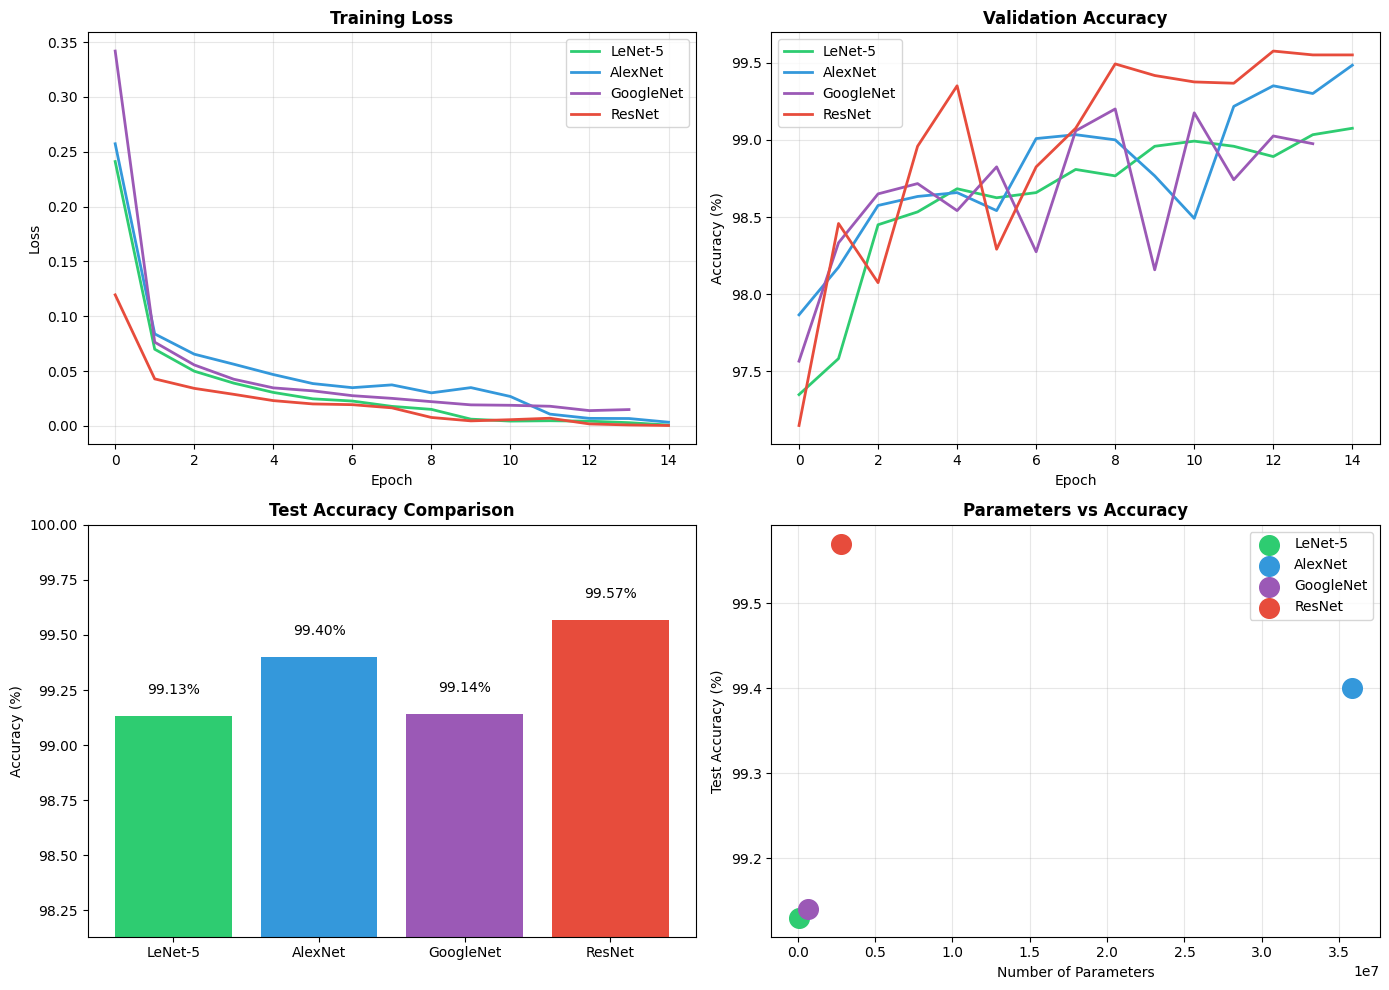

In [8]:
import os

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']

# Training Loss
ax1 = axes[0, 0]
for i, (name, hist) in enumerate(histories.items()):
    ax1.plot(hist['train_loss'], label=name, color=colors[i], linewidth=2)
ax1.set_title('Training Loss', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation Accuracy
ax2 = axes[0, 1]
for i, (name, hist) in enumerate(histories.items()):
    ax2.plot(hist['val_acc'], label=name, color=colors[i], linewidth=2)
ax2.set_title('Validation Accuracy', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Test Accuracy Bar Chart
ax3 = axes[1, 0]
accs = [results[m]['test_acc'] for m in results]
bars = ax3.bar(results.keys(), accs, color=colors)
ax3.set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
ax3.set_ylabel('Accuracy (%)')
ax3.set_ylim([min(accs)-1, 100])
for bar, acc in zip(bars, accs):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{acc:.2f}%', ha='center', fontsize=10)

# Parameters vs Accuracy
ax4 = axes[1, 1]
params = [results[m]['params'] for m in results]
for i, name in enumerate(results.keys()):
    ax4.scatter(params[i], accs[i], s=200, c=colors[i], label=name, zorder=5)
ax4.set_title('Parameters vs Accuracy', fontsize=12, fontweight='bold')
ax4.set_xlabel('Number of Parameters')
ax4.set_ylabel('Test Accuracy (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()

os.makedirs('results', exist_ok=True)
plt.savefig('results/comparison_plots.png', dpi=150, bbox_inches='tight')
plt.show()

### 8. Confusion Matrix untuk Setiap Model

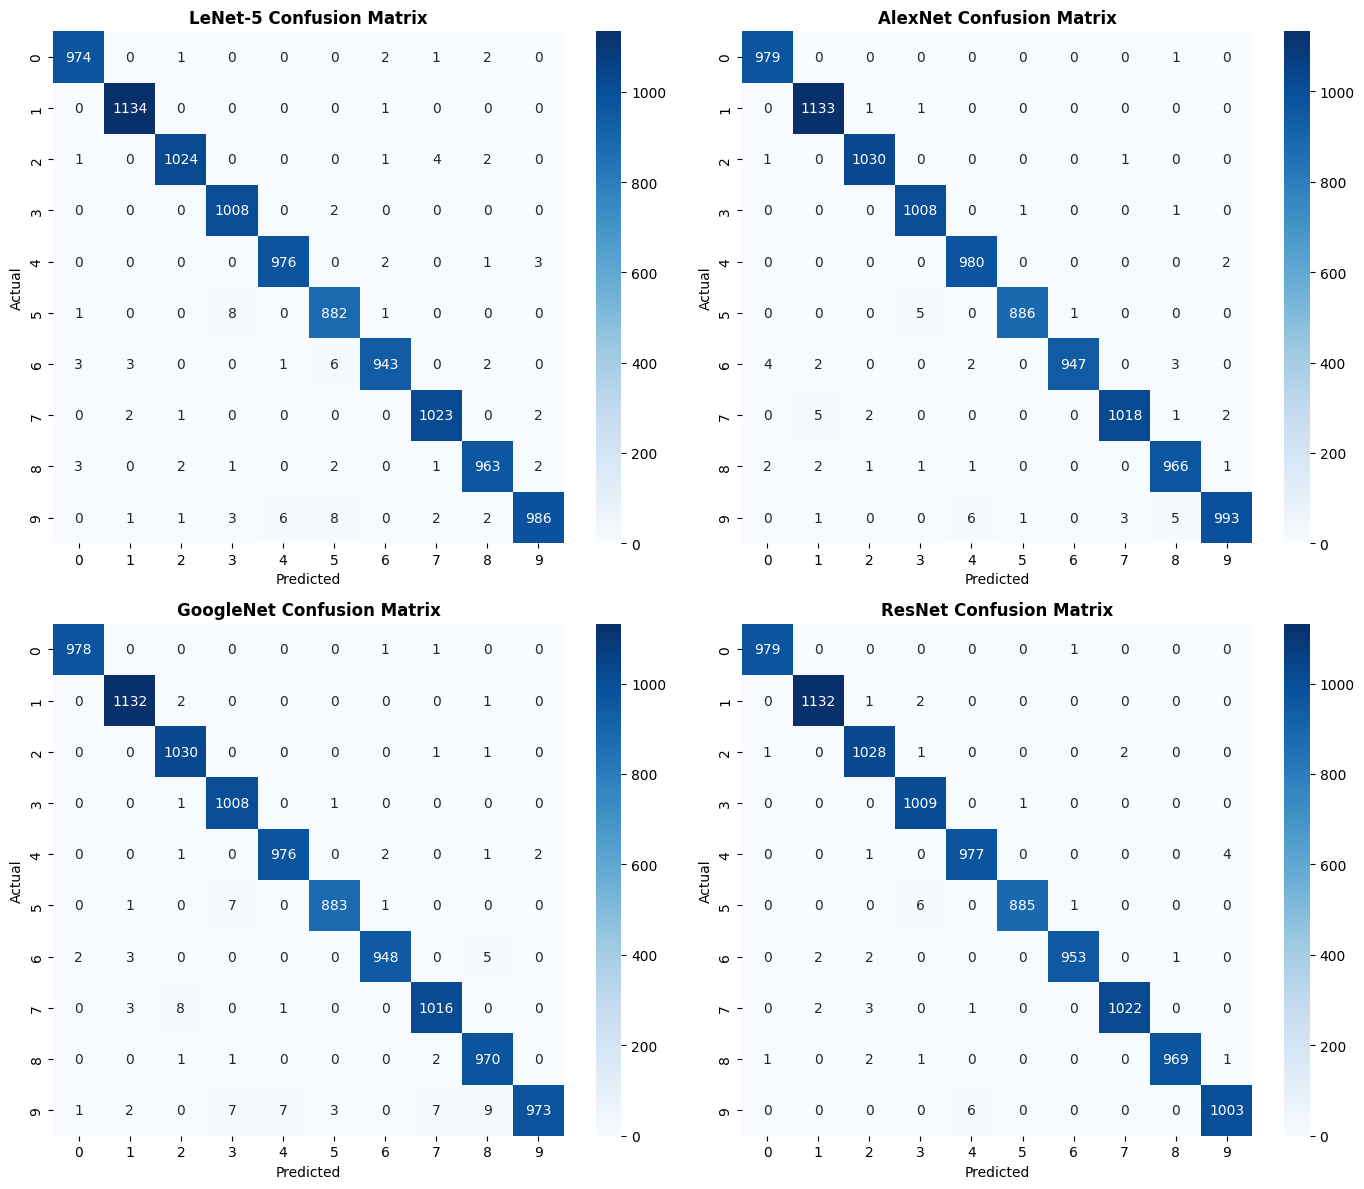

In [9]:
from sklearn.metrics import confusion_matrix, classification_report

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(res['labels'], res['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=range(10), yticklabels=range(10))
    axes[idx].set_title(f'{name} Confusion Matrix', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('results/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

### 9. Per-Class Accuracy Analysis

In [10]:
from sklearn.metrics import precision_recall_fscore_support

print("\n📊 Per-Class Metrics (Best Model)\n")
best_model = max(results.keys(), key=lambda x: results[x]['test_acc'])
print(f"Best Model: {best_model} ({results[best_model]['test_acc']:.2f}%)\n")

prec, rec, f1, _ = precision_recall_fscore_support(
    results[best_model]['labels'],
    results[best_model]['predictions'],
    average=None
)

metrics_df = pd.DataFrame({
    'Digit': range(10),
    'Precision': [f"{p:.4f}" for p in prec],
    'Recall': [f"{r:.4f}" for r in rec],
    'F1-Score': [f"{f:.4f}" for f in f1]
})
print(metrics_df.to_string(index=False))


📊 Per-Class Metrics (Best Model)

Best Model: ResNet (99.57%)

 Digit Precision Recall F1-Score
     0    0.9980 0.9990   0.9985
     1    0.9965 0.9974   0.9969
     2    0.9913 0.9961   0.9937
     3    0.9902 0.9990   0.9946
     4    0.9929 0.9949   0.9939
     5    0.9989 0.9922   0.9955
     6    0.9979 0.9948   0.9963
     7    0.9980 0.9942   0.9961
     8    0.9990 0.9949   0.9969
     9    0.9950 0.9941   0.9945


### 10. Summary & Kesimpulan

In [11]:
print("\n" + "="*60)
print("📝 KESIMPULAN")
print("="*60)

best = max(results.keys(), key=lambda x: results[x]['test_acc'])
fastest = min(results.keys(), key=lambda x: results[x]['inference_time'])
smallest = min(results.keys(), key=lambda x: results[x]['params'])

print(f"""
🏆 Best Accuracy: {best} ({results[best]['test_acc']:.2f}%)
⚡ Fastest Inference: {fastest} ({results[fastest]['inference_time']:.2f}ms)
📦 Smallest Model: {smallest} ({results[smallest]['params']:,} params)

📊 Trade-off Analysis:
- LeNet-5: Paling sederhana, cocok untuk deployment dengan resource terbatas
- AlexNet: Lebih dalam, performa bagus tapi parameter banyak
- GoogleNet: Inception modules efisien, balance antara akurasi dan kompleksitas
- ResNet: Skip connections membantu training, performa stabil
""")


📝 KESIMPULAN

🏆 Best Accuracy: ResNet (99.57%)
⚡ Fastest Inference: LeNet-5 (0.42ms)
📦 Smallest Model: LeNet-5 (82,826 params)

📊 Trade-off Analysis:
- LeNet-5: Paling sederhana, cocok untuk deployment dengan resource terbatas
- AlexNet: Lebih dalam, performa bagus tapi parameter banyak
- GoogleNet: Inception modules efisien, balance antara akurasi dan kompleksitas
- ResNet: Skip connections membantu training, performa stabil

